# Setup

In [1]:
#imports
import matplotlib.pyplot as plt
 
import pandas as pd
import itertools
import numpy as np
 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
)
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
 
import folium 

from itertools import combinations
 
#loading the Dataset into a pandas dataframe
df = pd.read_csv('Airlines.csv')
allAirports = pd.read_csv('hopefullyAllAirports.csv')

# Stage 1: Data Analysis

First, we want to know what the data is like:
Are there any outliers?
Do we need a scaler?
Which columns could have a high influence on the delay and which ones not?


data head:
   id Airline  Flight AirportFrom AirportTo  DayOfWeek  Time  Length  Delay
0   1      CO     269         SFO       IAH          3    15     205      1
1   2      US    1558         PHX       CLT          3    15     222      1
2   3      AA    2400         LAX       DFW          3    20     165      1
3   4      AA    2466         SFO       DFW          3    20     195      1
4   5      AS     108         ANC       SEA          3    30     202      0

data shape:
(539383, 9)

data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           539383 non-null  int64 
 1   Airline      539383 non-null  object
 2   Flight       539383 non-null  int64 
 3   AirportFrom  539383 non-null  object
 4   AirportTo    539383 non-null  object
 5   DayOfWeek    539383 non-null  int64 
 6   Time         539383 non-null  int64 
 7   Le

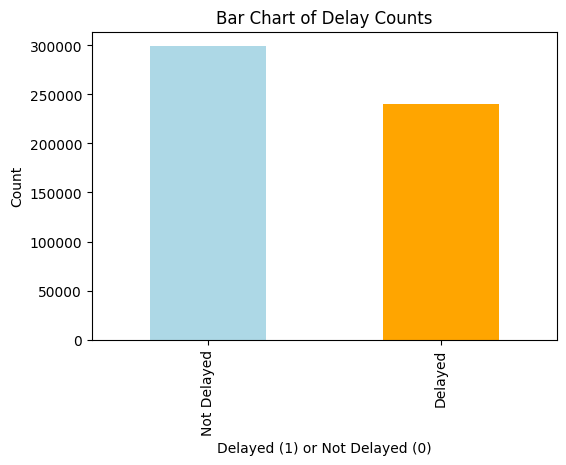

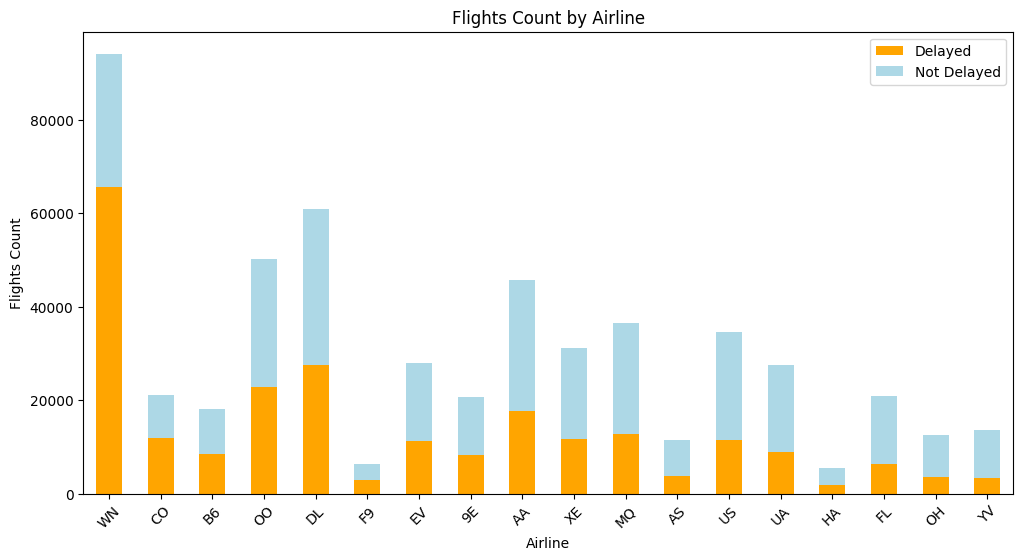

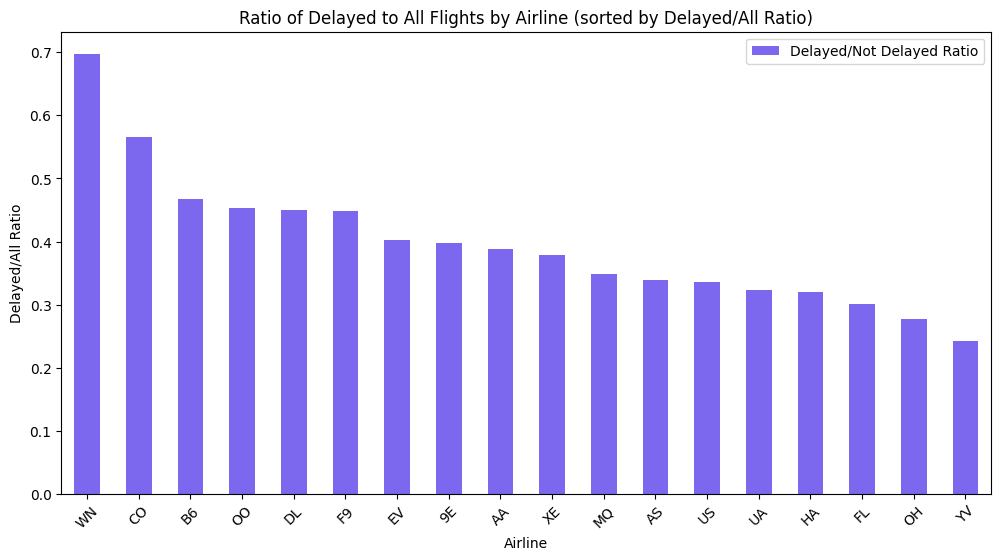

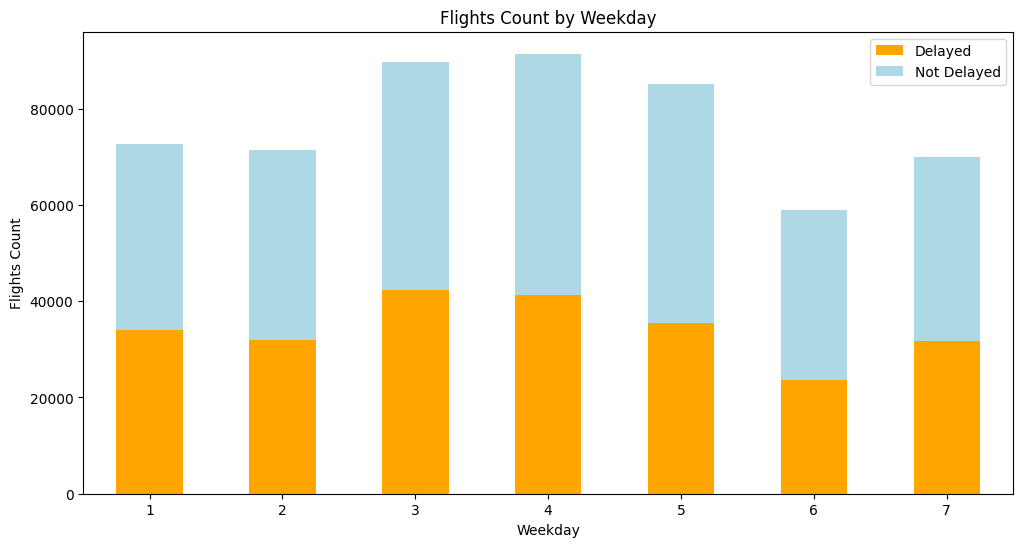

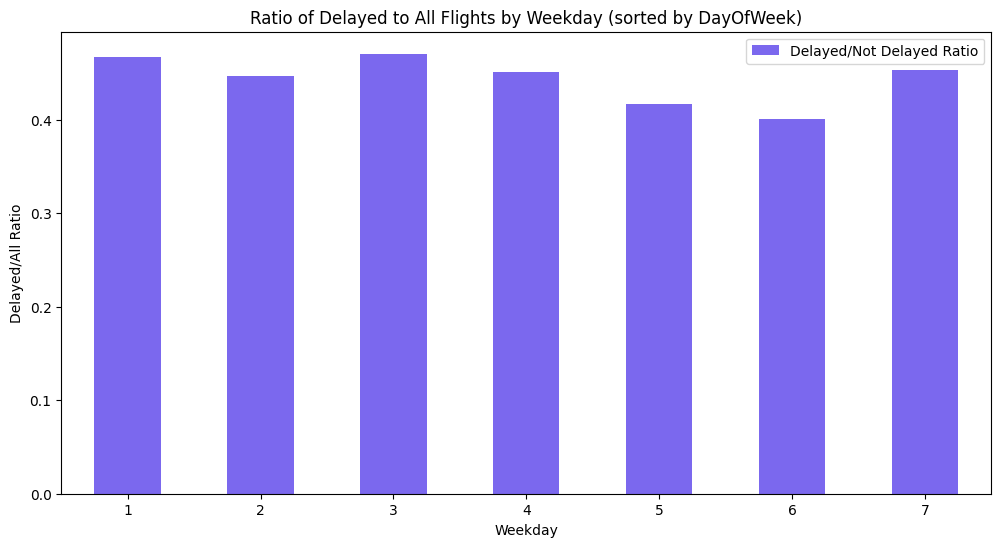

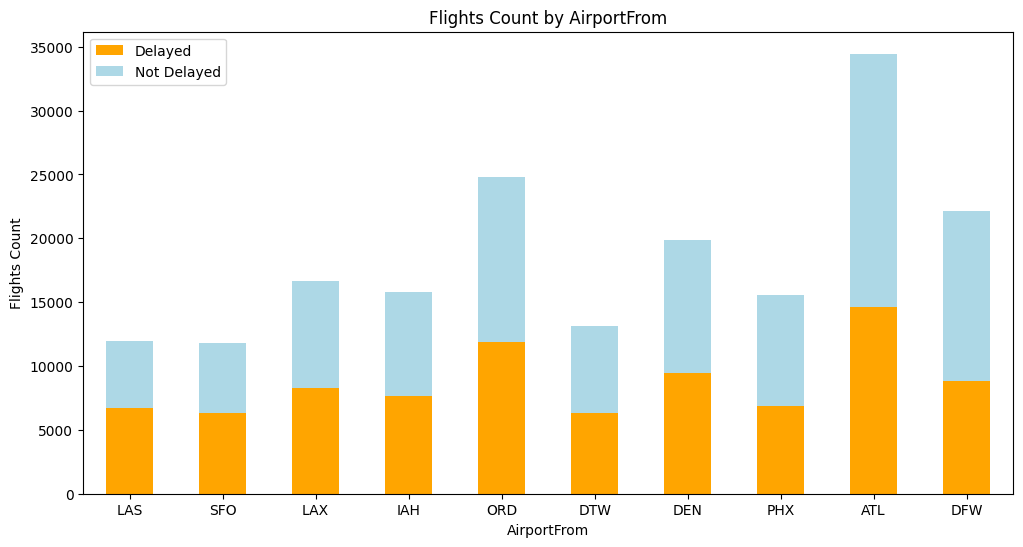

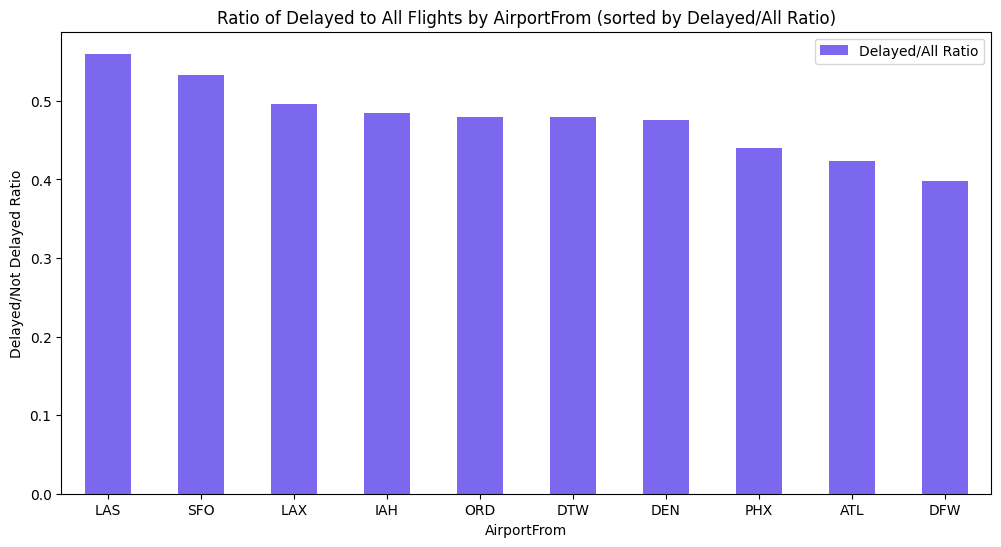

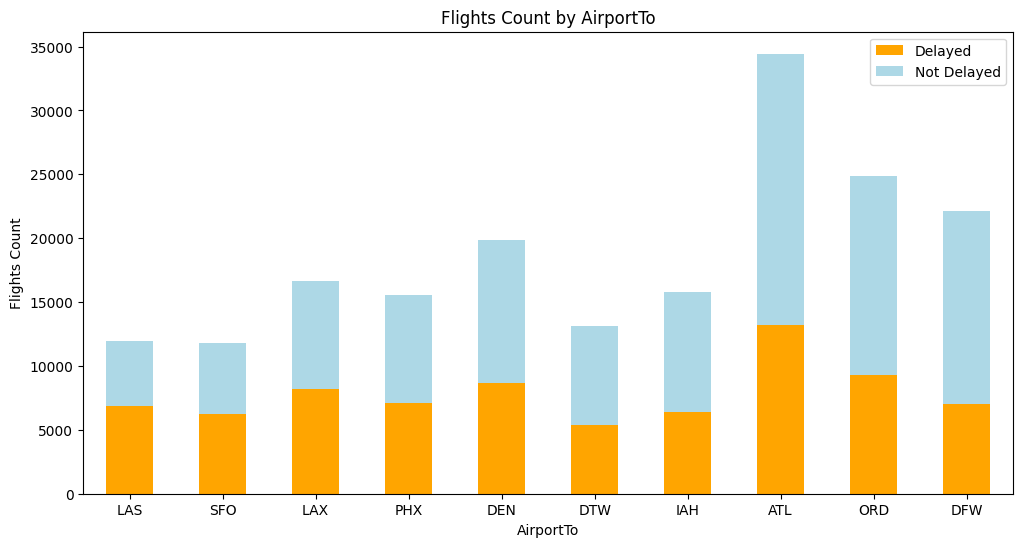

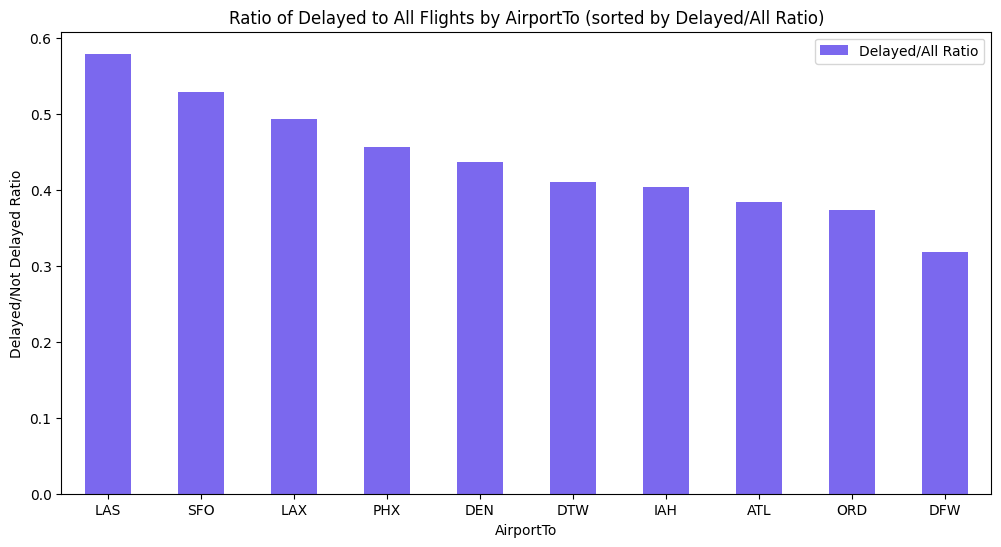

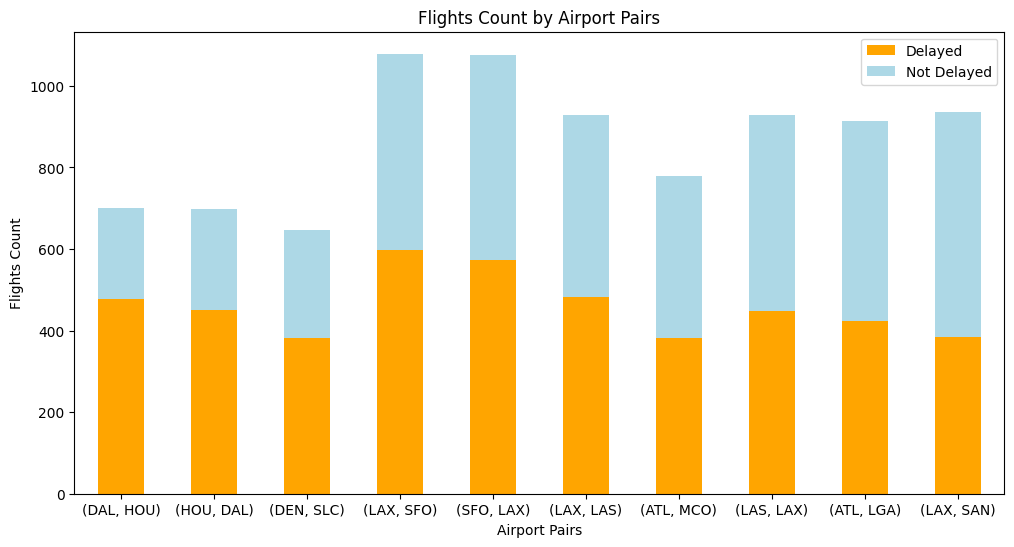

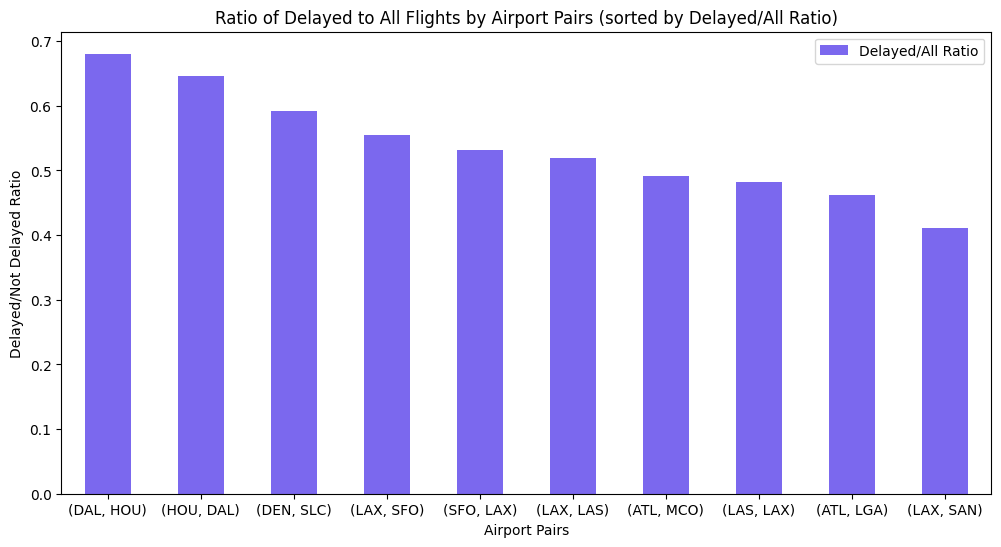

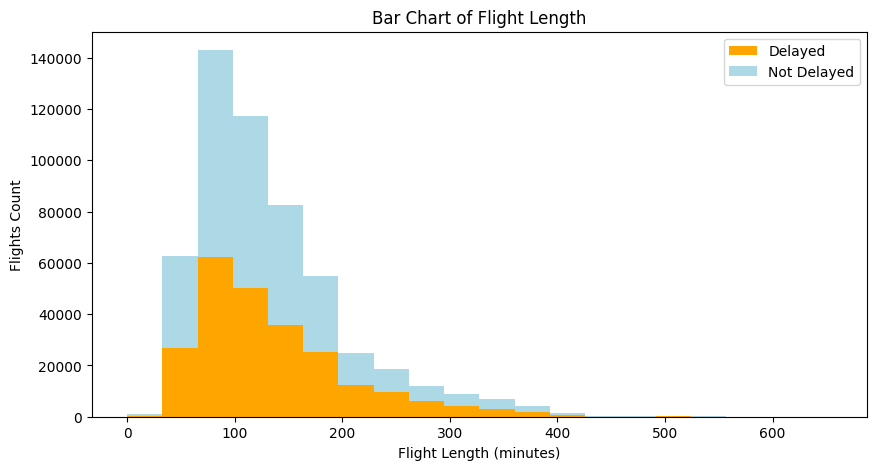

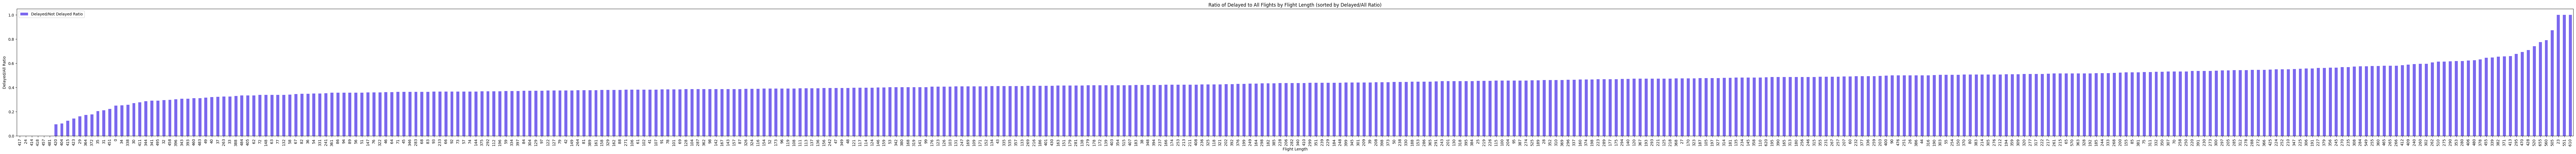

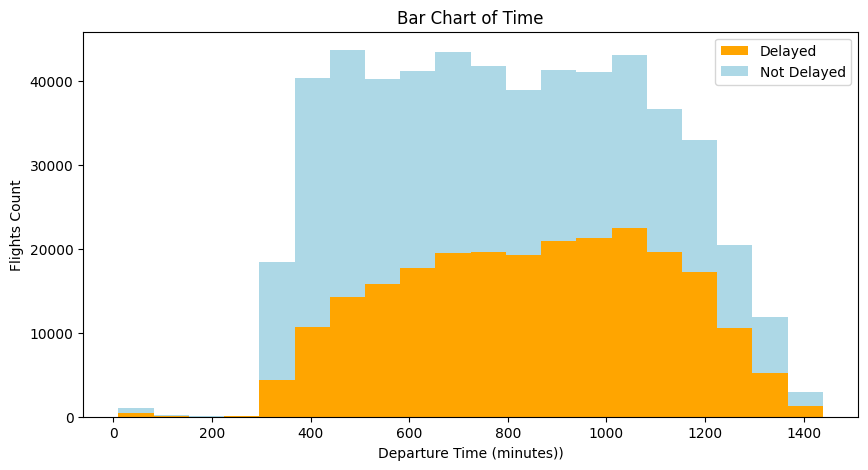

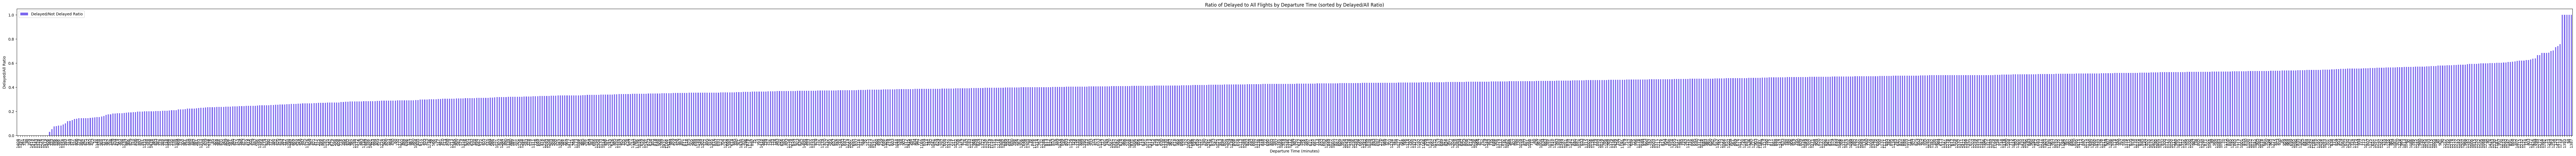

In [2]:
# Structure of the data:

print("\ndata head:")
print(df.head()) #Check table composition

print("\ndata shape:")
print(df.shape) #How many entries are there? (Get height and width of Dataset)

print("\ndata info:")
print(df.info()) #Check for empty datatuple

print("\ndata discription:")
print(df.describe()) #Data visualization -> Mean etc.

# Are there duplicates in our data?
duplicate_values = df.duplicated()
if duplicate_values.any:
    print("\nNo duplicates")
else:    
    print("\nDuplicates found")
    print(duplicate_values)

# Are there duplicated ids in our data?
duplicate_values = df['id'].duplicated()
if duplicate_values.any:
    print("\nNo duplicates id")
else:    
    print("\nDuplicates found id")
    print(duplicate_values)

#------------------------------------
# Interesting graphs:

colors = ['orange', 'lightblue']

# 1. Chart of Delay Counts
delay_counts = df['Delay'].value_counts()
print(delay_counts)

plt.figure(figsize=(6, 4))
delay_counts.plot(kind='bar', color=['lightblue', 'orange']) 
plt.xlabel('Delayed (1) or Not Delayed (0)')
plt.ylabel('Count')
plt.title('Bar Chart of Delay Counts')
plt.xticks([0, 1], ['Not Delayed', 'Delayed'])
plt.show()

#--------------------------------------

#2 Chart of Airline and Delay Count
delay_counts_by_airline = df.groupby('Airline')['Delay'].agg(['sum', 'count'])
delay_counts_by_airline['ratio'] = delay_counts_by_airline['sum'] / delay_counts_by_airline['count']
delay_counts_by_airline = delay_counts_by_airline.sort_values(by='ratio', ascending=False)

plt.figure(figsize=(12, 6))
delay_counts_by_airline['sum'].plot(kind='bar', color=colors[0], label='Delayed')
(delay_counts_by_airline['count'] - delay_counts_by_airline['sum']).plot(kind='bar', bottom=delay_counts_by_airline['sum'], color=colors[1], label='Not Delayed')
plt.xlabel('Airline')
plt.ylabel('Flights Count')
plt.title('Flights Count by Airline')
plt.legend(['Delayed', 'Not Delayed'])
plt.xticks(rotation=45)
plt.show()

# Ratio of Delayed to Not Delayed Flights by Airline
plt.figure(figsize=(12, 6))
delay_counts_by_airline['ratio'].plot(kind='bar', color="mediumslateblue")
plt.xlabel('Airline')
plt.ylabel('Delayed/All Ratio')
plt.title('Ratio of Delayed to All Flights by Airline (sorted by Delayed/All Ratio)')
plt.legend(['Delayed/Not Delayed Ratio'])
plt.xticks(rotation=45)
plt.show()

#------------------------------------------

# 3. Chart of DayOfWeek vs. Delay Counts
day_counts = df.groupby('DayOfWeek')['Delay'].agg(['sum', 'count'])
day_counts['ratio'] = day_counts['sum'] / day_counts['count']
day_counts = day_counts.sort_values(by='DayOfWeek', ascending=True)

plt.figure(figsize=(12, 6))
day_counts['sum'].plot(kind='bar', color=colors[0], label='Delayed')
(day_counts['count'] - day_counts['sum']).plot(kind='bar', bottom=day_counts['sum'], color=colors[1], label='Not Delayed')
plt.xlabel('Weekday')
plt.ylabel('Flights Count')
plt.title('Flights Count by Weekday')
plt.legend(['Delayed', 'Not Delayed'])
plt.xticks(rotation=0)
plt.show()

# Ratio of Delayed to Not Delayed Flights by Airline
plt.figure(figsize=(12, 6))
day_counts['ratio'].plot(kind='bar', color="mediumslateblue")
plt.xlabel('Weekday')
plt.ylabel('Delayed/All Ratio')
plt.title('Ratio of Delayed to All Flights by Weekday (sorted by DayOfWeek)')
plt.legend(['Delayed/Not Delayed Ratio'])
plt.xticks(rotation=0)
plt.show()

#------------------------------------------

# 4.1 Chart of AirportFrom and Delay Counts
airportFrom_counts = df.groupby(['AirportFrom'])['Delay'].agg(['sum', 'count']).nlargest(10, 'sum')
airportFrom_counts['ratio'] = airportFrom_counts['sum'] / airportFrom_counts['count']
airportFrom_counts = airportFrom_counts.sort_values(by='ratio', ascending=False)

plt.figure(figsize=(12, 6))
airportFrom_counts['sum'].plot(kind='bar', color=colors[0], label='Delayed')
(airportFrom_counts['count'] - airportFrom_counts['sum']).plot(kind='bar', bottom=airportFrom_counts['sum'], color=colors[1], label='Not Delayed')
plt.xlabel('AirportFrom')
plt.ylabel('Flights Count')
plt.title('Flights Count by AirportFrom')
plt.legend(['Delayed', 'Not Delayed'])
plt.xticks(rotation=0)
plt.show()

# Ratio of Delayed to Not Delayed Flights by AirportFrom
plt.figure(figsize=(12, 6))
airportFrom_counts['ratio'].plot(kind='bar', color="mediumslateblue")
plt.xlabel('AirportFrom')
plt.ylabel('Delayed/Not Delayed Ratio')
plt.title('Ratio of Delayed to All Flights by AirportFrom (sorted by Delayed/All Ratio)')
plt.legend(['Delayed/All Ratio'])
plt.xticks(rotation=0)
plt.show()


# 4.2 Chart of AirportTo and Delay Counts
airportTo_counts = df.groupby(['AirportTo'])['Delay'].agg(['sum', 'count']).nlargest(10, 'sum')
airportTo_counts['ratio'] = airportTo_counts['sum'] / airportTo_counts['count']
airportTo_counts = airportTo_counts.sort_values(by='ratio', ascending=False)

plt.figure(figsize=(12, 6))
airportTo_counts['sum'].plot(kind='bar', color=colors[0], label='Delayed')
(airportTo_counts['count'] - airportTo_counts['sum']).plot(kind='bar', bottom=airportTo_counts['sum'], color=colors[1], label='Not Delayed')
plt.xlabel('AirportTo')
plt.ylabel('Flights Count')
plt.title('Flights Count by AirportTo')
plt.legend(['Delayed', 'Not Delayed'])
plt.xticks(rotation=0)
plt.show()

# Ratio of Delayed to Not Delayed Flights by AirportTo
plt.figure(figsize=(12, 6))
airportTo_counts['ratio'].plot(kind='bar', color="mediumslateblue")
plt.xlabel('AirportTo')
plt.ylabel('Delayed/Not Delayed Ratio')
plt.title('Ratio of Delayed to All Flights by AirportTo (sorted by Delayed/All Ratio)')
plt.legend(['Delayed/All Ratio'])
plt.xticks(rotation=0)
plt.show()


# 4.3 Chart of Airport Pairs and Delay Counts
airport_pairs_counts = df.groupby(['AirportFrom', 'AirportTo'])['Delay'].agg(['sum', 'count']).nlargest(10, 'sum')
airport_pairs_counts['ratio'] = airport_pairs_counts['sum'] / airport_pairs_counts['count']
airport_pairs_counts = airport_pairs_counts.sort_values(by='ratio', ascending=False)

plt.figure(figsize=(12, 6))
airport_pairs_counts['sum'].plot(kind='bar', color=colors[0], label='Delayed')
(airport_pairs_counts['count'] - airport_pairs_counts['sum']).plot(kind='bar', bottom=airport_pairs_counts['sum'], color=colors[1], label='Not Delayed')
plt.xlabel('Airport Pairs')
plt.ylabel('Flights Count')
plt.title('Flights Count by Airport Pairs')
plt.legend(['Delayed', 'Not Delayed'])
plt.xticks(rotation=0)
plt.show()

# Ratio of Delayed to Not Delayed Flights by Airport Pairs
plt.figure(figsize=(12, 6))
airport_pairs_counts['ratio'].plot(kind='bar', color="mediumslateblue")
plt.xlabel('Airport Pairs')
plt.ylabel('Delayed/Not Delayed Ratio')
plt.title('Ratio of Delayed to All Flights by Airport Pairs (sorted by Delayed/All Ratio)')
plt.legend(['Delayed/All Ratio'])
plt.xticks(rotation=0)
plt.show()

#------------------------------------------

# 5. Chart of Flight Length and Delay Counts
plt.figure(figsize=(10, 5))
plt.hist([df[df['Delay'] == 1]['Length'], df[df['Delay'] == 0]['Length']], bins=20, color=colors, stacked=True)
plt.xlabel('Flight Length (minutes)')
plt.ylabel('Flights Count')
plt.title('Bar Chart of Flight Length')
plt.legend(['Delayed', 'Not Delayed'])
plt.show()

length_counts = df.groupby(['Length'])['Delay'].agg(['sum', 'count'])
length_counts['ratio'] = length_counts['sum'] / length_counts['count']
length_counts = length_counts.sort_values(by='ratio', ascending=True)

# Ratio of Delayed to Not Delayed Flights by Flight Length
plt.figure(figsize=(120, 6))
length_counts['ratio'].plot(kind='bar', color="mediumslateblue")
plt.xlabel('Flight Length')
plt.ylabel('Delayed/All Ratio')
plt.title('Ratio of Delayed to All Flights by Flight Length (sorted by Delayed/All Ratio)')
plt.legend(['Delayed/Not Delayed Ratio'])
plt.xticks(rotation=90)
plt.show()

#------------------------------------------

# 6. Chart of Time and Delay Counts
plt.figure(figsize=(10, 5))
plt.hist([df[df['Delay'] == 1]['Time'], df[df['Delay'] == 0]['Time']], bins=20, color=colors, stacked=True)
plt.xlabel('Departure Time (minutes))')
plt.ylabel('Flights Count')
plt.title('Bar Chart of Time')
plt.legend(['Delayed', 'Not Delayed'])
plt.show()

time_counts = df.groupby(['Time'])['Delay'].agg(['sum', 'count'])
time_counts['ratio'] = time_counts['sum'] / time_counts['count']
time_counts = time_counts.sort_values(by='ratio', ascending=True)

# Ratio of Delayed to Not Delayed Flights by Time
plt.figure(figsize=(120, 6))
time_counts['ratio'].plot(kind='bar', color="mediumslateblue")
plt.xlabel('Departure Time (minutes)')
plt.ylabel('Delayed/All Ratio')
plt.title('Ratio of Delayed to All Flights by Departure Time (sorted by Delayed/All Ratio)')
plt.legend(['Delayed/Not Delayed Ratio'])
plt.xticks(rotation=90)
plt.show()




We printed the head of the data table to see whether we need an encoder or not. As we have columns filled with text rather than numbers, we decided to use an Ordinal Encoder.
On the basis of these graphs we decided to use a Standard Scaler to avert the different columns from having a different influence level in the Data Models (because the scales the numbers of the columns are in are varying).
Also, on basis of the different ratios, we assume that the columns Airline, AirportTo, Lenth and Time have an actual impact on the delay. The rest of the columns might not be needed to be revised by the Data Model to get a good forecast. We will try that out later after deciding on a Model.

## Map

Where are the Airports?

In [3]:
dfFrom = df["AirportFrom"].unique()
dfTo = df["AirportTo"].unique()

# Concatenate those two arrays to one
dfAirports = np.concatenate((dfFrom, dfTo), axis=None)

# Remove duplicates
dfAirports = np.unique(dfAirports)
print("\nAirports count:")
print(dfAirports.shape)

# Convert dfAirports to a DataFrame
dfAirports = pd.DataFrame({'iata_code': dfAirports})

# Convert 'iata_code' columns to strings
dfAirports['iata_code'] = dfAirports['iata_code'].astype(str)
allAirports['iata_code'] = allAirports['iata_code'].astype(str)

# Merge dataframes based on the 'iata_code' column
merged_dataframe = pd.merge(dfAirports, allAirports, on='iata_code', how='left')

print("\nmerged_dataframe:")
print(merged_dataframe.shape)


# Extract latitude and longitude from the 'coordinates' column
merged_dataframe[['longitude', 'latitude']] = merged_dataframe['coordinates'].str.split(', ', expand=True).astype(float)

# Create a folium map centered around the first entry
m = folium.Map(location=[merged_dataframe['latitude'].iloc[0], merged_dataframe['longitude'].iloc[0]], zoom_start=10)

# Add markers for each entry
for index, row in merged_dataframe.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['name']).add_to(m)

# Display the map
m




Airports count:
(293,)

merged_dataframe:
(293, 12)


# Stage 2: Data Preprocessing

We now prepare the data so that we can use it in the Data Models. 
As already mentioned above, we decided to apply an Ordinal Encoder and a Standard Scaler. After that we make a train and test data split of 80% training and 20% test data.

In [2]:
# Select features and target variable (id is not needed)
features = ['Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Time', 'Length']
target = 'Delay'
X = df[features]
y = df[target]

#Preprossing of the data
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)

encoder = preprocessing.OrdinalEncoder()
encoded = pd.DataFrame(encoder.fit_transform(X[['Airline', 'AirportFrom', 'AirportTo']]), columns = encoder.get_feature_names_out(['Airline', 'AirportFrom', 'AirportTo']))

X = X.drop(columns = ['Airline', 'AirportFrom', 'AirportTo'])
X = X.join(encoded)

# Separate continuous and categorical columns
continuous_cols = ['DayOfWeek', 'Time', 'Length']
categorical_cols = [col for col in X.columns if col not in continuous_cols]


# Apply StandardScaler only to continuous columns
scaler = StandardScaler()
X[continuous_cols] = scaler.fit_transform(X[continuous_cols])


print(X)
print(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training and 20% testing

        DayOfWeek      Time    Length  Airline  AirportFrom  AirportTo
0       -0.485552 -2.833092  1.038237      4.0        253.0      135.0
1       -0.485552 -2.833092  1.280689     14.0        217.0       60.0
2       -0.485552 -2.815110  0.467761      1.0        154.0       80.0
3       -0.485552 -2.815110  0.895618      1.0        253.0       80.0
4       -0.485552 -2.779144  0.995451      2.0         14.0      252.0
...           ...       ...       ...      ...          ...        ...
539378   0.559019  2.288369  2.763925      4.0        203.0      264.0
539379   0.559019  2.288369  2.464425      8.0        252.0       16.0
539380   0.559019  2.288369  1.751331      8.0        253.0      184.0
539381   0.559019  2.288369  2.578520     13.0        128.0      253.0
539382   0.559019  2.288369  2.407378     14.0        154.0      216.0

[539383 rows x 6 columns]
[1 1 1 ... 0 1 1]


# Different Data Models

In the following, we tried out different data models and checked the accuracy, precision, recall and f1. To decide on a specific model we agreed on using the best accuracy. We primarily did not decide for precision, recall or f1 because these measurements are especially used for infrequent data which we do not have. We nearly have the same amounts of delayed and undelayed flights.

Each time, we also plotted the accuracy of the training data to be sure from which point on the model is overfitting.

## KNN

In [5]:
# Create arrays to store max_depth and corresponding accuracies
k_count = []
precisions = []
recalls = []
f1_scores = []
accuracies = []
trainAccuracies = []

k_range = 21 #rule of thumb 1-20
for k in range(1, k_range):
    k_count.append(k)

    # create an KNN Classifier
    knn_estimator = KNeighborsClassifier(n_neighbors = k, algorithm='ball_tree') #use ball_tree algorithm to have a shorter runtime
    # train with trainingsdata
    knn_estimator.fit(X_train, y_train)
    #predict test data
    predicted_knn = knn_estimator.predict(X_test) 
    
    #------------------------------------

    # measurements:

    accuracy = accuracy_score(y_test, predicted_knn)
    accuracies.append(accuracy)

    recall = recall_score(y_test, predicted_knn, average='weighted')
    recalls.append(recall)

    precision = precision_score(y_test, predicted_knn, average='weighted')
    precisions.append(precision)
    
    f1 = f1_score(y_test, predicted_knn, average='weighted')
    f1_scores.append(f1)
    

    # For comparison predict on training data
    y_predTrain = knn_estimator.predict(X_train)
    trainAccuracy = accuracy_score(y_train, y_predTrain)
    trainAccuracies.append(trainAccuracy)
    
    print(f"K: {k}, Test Accuracy:  {accuracy}, Precision: {precision}, Recall: {recall}, f1: {f1}")
    print(f"K: {k}, Train Accuracy: {trainAccuracy}")

#------------------------------

# plot accuracies of training and test data

plt.figure(figsize=(20, 10))
plt.plot(k_count, accuracies, marker='o', label='Accuracy')
plt.plot(k_count, trainAccuracies, marker='o', label='Accuracy')

plt.title('k vs. Accuracy')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("graphs/knn.pdf")
plt.show()


K: 1, Test Accuracy:  0.5929623552749891, Precision: 0.5928284827814478, Recall: 0.5929623552749891, f1: 0.592894120767667
K: 1, Train Accuracy: 0.7901187932496883
K: 2, Test Accuracy:  0.6110199579150328, Precision: 0.6128196182900943, Recall: 0.6110199579150328, f1: 0.5825984599667124
K: 2, Train Accuracy: 0.762246643152123
K: 3, Test Accuracy:  0.6178147334464251, Precision: 0.6164203095967928, Recall: 0.6178147334464251, f1: 0.6169168387680289
K: 3, Train Accuracy: 0.7860284677385714
K: 4, Test Accuracy:  0.6307275879010354, Precision: 0.6304255639087254, Recall: 0.6307275879010354, f1: 0.6148566851361659
K: 4, Train Accuracy: 0.7491344268677608
K: 5, Test Accuracy:  0.6343520861722146, Precision: 0.6323025703451687, Recall: 0.6343520861722146, f1: 0.632708505430572
K: 5, Train Accuracy: 0.7519177021872233
K: 6, Test Accuracy:  0.6432789195101829, Precision: 0.642807159219435, Recall: 0.6432789195101829, f1: 0.6312081895154035
K: 6, Train Accuracy: 0.7323768383290151
K: 7, Test Acc

KeyboardInterrupt: 

## Naive Bayes

In [ ]:
#Create an NB Classifier
nb_estimator = GaussianNB()

# Train the classifier on the training set
nb_estimator.fit(X_train,y_train)

# Make predictions on the testing set
y_pred = nb_estimator.predict(X_test)

#-----------------------------------------

# measurements:

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

f1 = f1_score(y_pred, y_test, average="weighted")
print("F1 Score:", f1)

Accuracy: 0.5819034641304448
Precision: 0.5450780106505558
Recall: 0.36466102754281426
F1 Score: 0.5988772205297175


## Neural Network

In [ ]:
# MLPClassifier with 10 hidden layers, learning rate = 0.01 and mayximum iterations = 500    
neuralnet = MLPClassifier(hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=500)

# Train the neural network
neuralnet.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = neuralnet.predict(X_test)

# Calculate and print the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

# Calculate and print precision, recall, and f1-score
precision = precision_score(y_test, y_pred)

recall = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

print(f"Neural Network:, Test Accuracy:  {accuracy}, Precision: {precision}, Recall: {recall}, f1: {f1}")




Now, our two best models will follow. Their accuracies are very similar. This is why we also decided to decide in a second step on f1 and precision. 
For our business case, precision is more important than recall because it is worse when the model is wrong with the prediction that a flight will be late than when it is right about being late.

## Random Forest

In [ ]:
# Create arrays to store max_depth and corresponding accuracies
depths = []
accuracies = []
trainAccuracies = []

# Loop through max depths
for max_tree_depth in range(1, 9):

    # Create a Random Forest classifier within a pipeline
    clf = Pipeline([
    ('classifier', RandomForestClassifier(n_estimators=100, criterion='gini', max_depth= max_tree_depth))])

    # Train the classifier on the training set
    clf.fit(X_train, y_train)

    # Make predictions on the testing set
    y_pred = clf.predict(X_test)

    # For comparison predict on training data
    y_predTrain = clf.predict(X_train)
    trainAccuracy = accuracy_score(y_train, y_predTrain) 

    #-----------------------------------------------------

    # measurements:
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred) 
    f1 = f1_score(y_test, y_pred) 

    print(f"Max Depth: {max_tree_depth}, Test Accuracy:  {accuracy}, Precision: {precision}, Recall: {recall}, f1: {f1}")
    print(f"Max Depth: {max_tree_depth}, Train Accuracy: {trainAccuracy}")
    
    depths.append(max_tree_depth)
    accuracies.append(accuracy)
    trainAccuracies.append(trainAccuracy)

# Plotting the graph
plt.plot(depths, trainAccuracies, marker= 'o', label = "Training data")
plt.plot(depths, accuracies, marker='o', label = "Test data")
plt.title('Max Depth vs. Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("graphs/randomForest.pdf")
plt.show()

Max Depth: 1, Test Accuracy:  0.5942415899589347, Precision: 0.6745415496448043, Recall: 0.17013208883703487, f1: 0.2717290030613603
Max Depth: 1, Train Accuracy: 0.5941887250698715
Max Depth: 2, Test Accuracy:  0.6140326482938903, Precision: 0.6565283724592745, Recall: 0.2779282470102921, f1: 0.390532371152129
Max Depth: 2, Train Accuracy: 0.6141374627467521
Max Depth: 3, Test Accuracy:  0.6190476190476191, Precision: 0.6844862610926975, Recall: 0.2667611150464603, f1: 0.3839050131926121
Max Depth: 3, Train Accuracy: 0.6190922026576687
Max Depth: 4, Test Accuracy:  0.6274553426587688, Precision: 0.7307487737131375, Recall: 0.2576149006208592, f1: 0.38093624362667317
Max Depth: 4, Train Accuracy: 0.6264941854806191
Max Depth: 5, Test Accuracy:  0.6348526562659325, Precision: 0.7293609763897031, Recall: 0.28511604650193756, f1: 0.40996989260196814
Max Depth: 5, Train Accuracy: 0.633372421240956
Max Depth: 6, Test Accuracy:  0.6383659167385077, Precision: 0.7159680830609498, Recall: 0.31

## Decision Tree

Max Depth: 1, Test Accuracy:  0.5956876813407863, Precision: 0.5787789443405724, Recall: 0.3353681403391808, f1: 0.4246669304841049
Max Depth: 1, Train Accuracy: 0.5967054919282698
Max Depth: 2, Test Accuracy:  0.6247578260426226, Precision: 0.700351774864087, Recall: 0.2737614067252802, f1: 0.3936488915518274
Max Depth: 2, Train Accuracy: 0.6232566870449079
Max Depth: 3, Test Accuracy:  0.6261668381582729, Precision: 0.7691605839416058, Recall: 0.22832201341722572, f1: 0.35211901166340004
Max Depth: 3, Train Accuracy: 0.6243945623004084
Max Depth: 4, Test Accuracy:  0.6309500634982433, Precision: 0.6135556542004217, Recall: 0.46074836451518814, f1: 0.5262844768092144
Max Depth: 4, Train Accuracy: 0.6278128229966675
Max Depth: 5, Test Accuracy:  0.6377633786627362, Precision: 0.6583590726736962, Recall: 0.3863494312263011, f1: 0.4869428215059411
Max Depth: 5, Train Accuracy: 0.6368254439103975
Max Depth: 6, Test Accuracy:  0.6401364516996209, Precision: 0.6667393437261528, Recall: 0.38

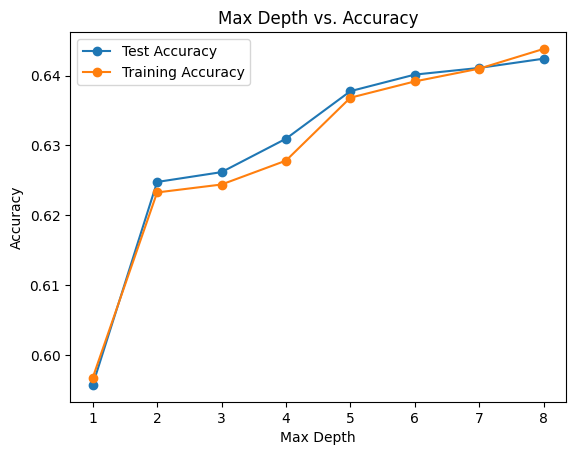

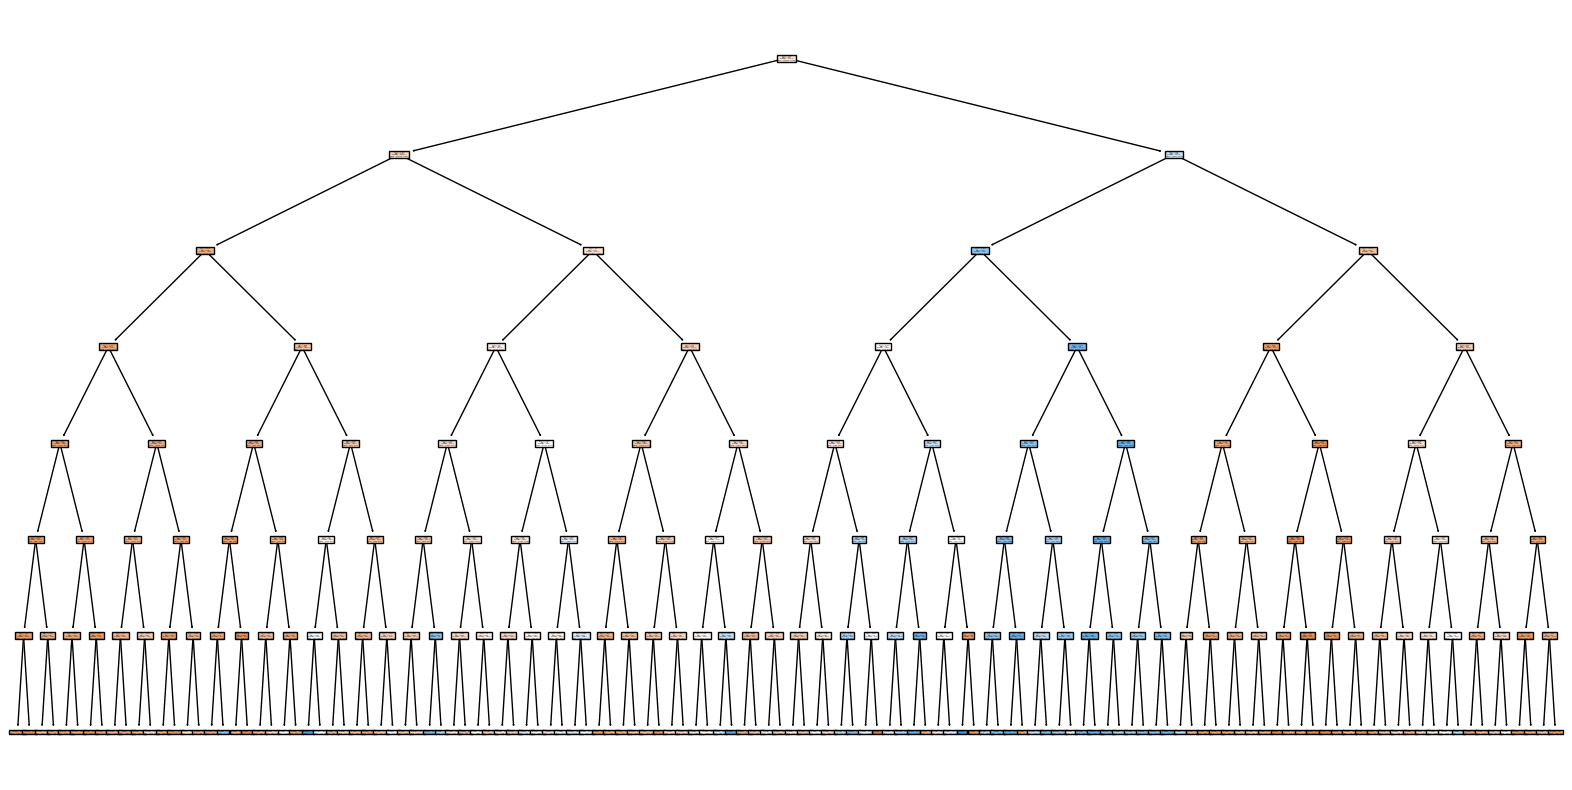

In [ ]:
# Create arrays to store max_depth and corresponding accuracies
depths = []
accuracies = []
trainingAccuracies = []

# Loop through max depths from 1 to 9
for max_tree_depth in range(1, 9):

    # Create a Decision Tree classifier within a pipeline
    clf = Pipeline([
        ('classifier', DecisionTreeClassifier(max_depth=max_tree_depth, random_state=42))
    ])

    # Train the classifier on the training set
    clf.fit(X_train, y_train)

    if max_tree_depth == 7:
        clfSeven = clf

    # Make predictions on the testing set
    y_pred = clf.predict(X_test)
    y_test_pred = clf.predict(X_train)

    # Calculate the accuracy, precision, recall and f1 of the classifier
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    trainAccuracy = accuracy_score(y_train, y_test_pred)

    print(f"Max Depth: {max_tree_depth}, Test Accuracy:  {accuracy}, Precision: {precision}, Recall: {recall}, f1: {f1}")
    print(f"Max Depth: {max_tree_depth}, Train Accuracy: {trainAccuracy}")

    # Store depth and accuracy in arrays
    depths.append(max_tree_depth)
    accuracies.append(accuracy)
    trainingAccuracies.append(trainAccuracy)

# Plotting the graph
plt.plot(depths, accuracies, marker='o', label = "Test Accuracy")
plt.plot(depths, trainingAccuracies, marker ='o', label = "Training Accuracy")
plt.title('Max Depth vs. Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("graphs/dtAcc.pdf")
plt.show()

# Plot the decision tree with depth 7
plt.figure(figsize=(20, 10))
plot_tree(clfSeven['classifier'], filled=True)
plt.savefig("graphs/dt.pdf")
plt.show()

As the Random Forest model is only a bit better in precision but the Decision Tree is better in f1 and better in the runtime, we finally decided on using the Decision Tree.

# Evaluation of the Decision Tree

## Cross validation

To have more precise measurements, we added cross validation to the model.

Max Depth: 1, CV Mean Acc: 0.5550673453315581
Max Depth: 1, CV Mean Acc: 0.5967054910119737
Max Depth: 2, CV Mean Acc: 0.6083317204515897
Max Depth: 2, CV Mean Acc: 0.6232566860056582
Max Depth: 3, CV Mean Acc: 0.62548085873708
Max Depth: 3, CV Mean Acc: 0.6237317674068006
Max Depth: 4, CV Mean Acc: 0.6324239894032725
Max Depth: 4, CV Mean Acc: 0.62736787036029


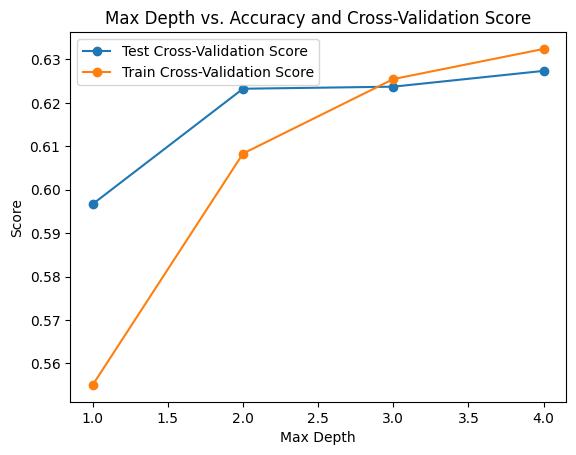

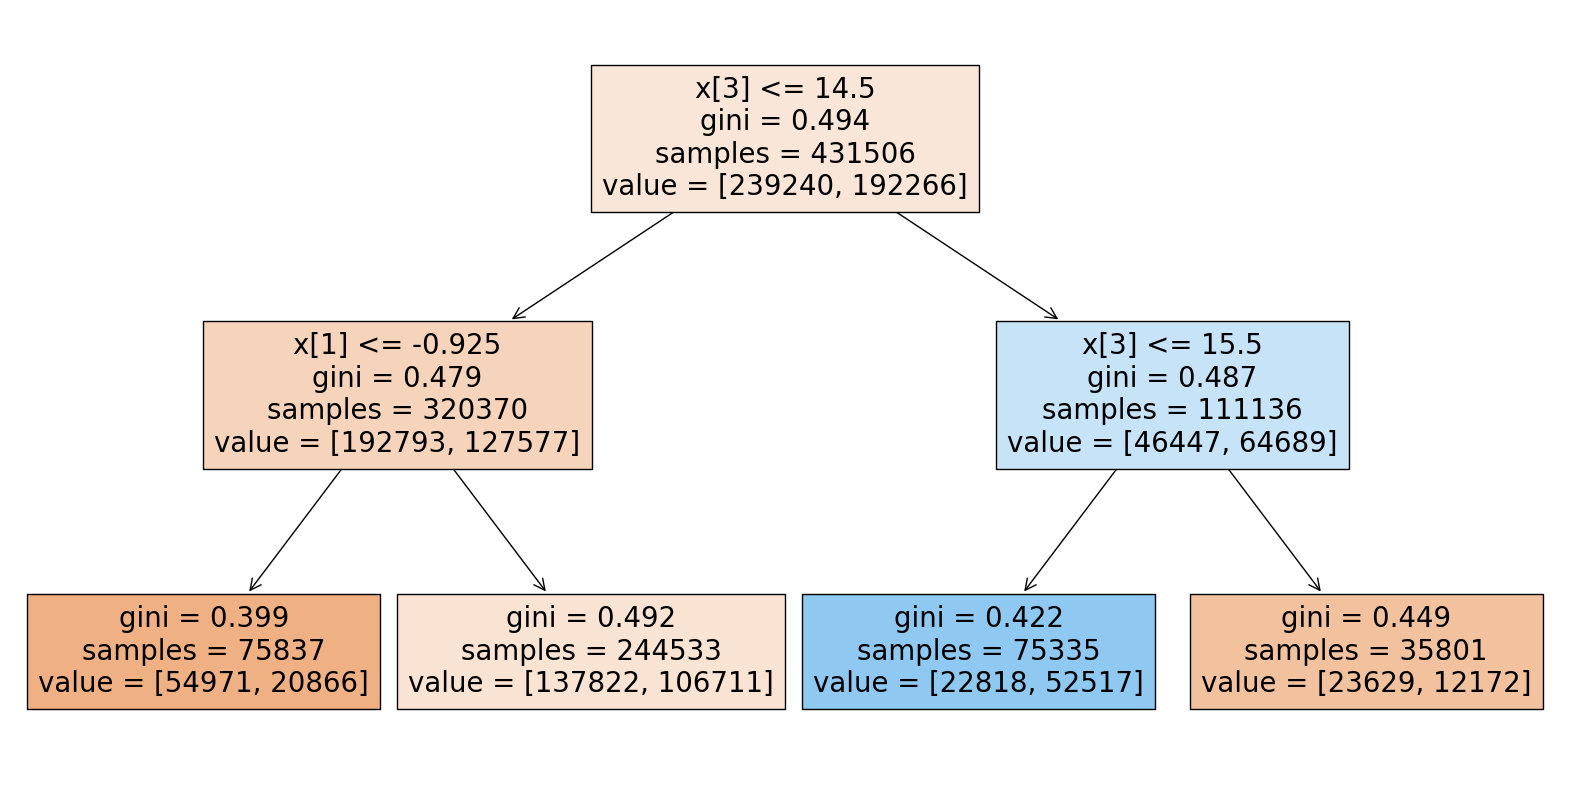

In [ ]:
# Create arrays to store max_depth, corresponding accuracies, and cross-validation scores
depths = []
accuracies = []
trainingAccuracies = []
cross_val_test_scores = []
cross_val_train_scores = []

# Loop through max depths from 1 to 5
for max_tree_depth in range(1, 5):

    # Create a Decision Tree classifier within a pipeline
    clf = Pipeline([
        ('classifier', DecisionTreeClassifier(max_depth=max_tree_depth, random_state=42))
    ])

    # Cross-validation
    cross_val_result = cross_val_score(clf, X_train, y_train, cv=5, n_jobs = -1) #n_jobs = -1 improves the runtime
    cross_val_train_scores.append(np.mean(cross_val_result))

    cross_val_result = cross_val_score(clf, X_test, y_test, cv=5, n_jobs = -1)
    cross_val_test_scores.append(np.mean(cross_val_result))

    # Train the classifier on the training set
    clf.fit(X_train, y_train)

    if max_tree_depth == 2:
        clfTwo = clf

    # Make predictions on the testing set
    y_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X_train)

    # Confusion Matrix --> used later
    if max_tree_depth == 2:
        cm = confusion_matrix(y_test, y_pred)

    print(f"Max Depth: {max_tree_depth}, CV Mean Acc: {cross_val_test_scores[-1]}")
    print(f"Max Depth: {max_tree_depth}, CV Mean Acc: {cross_val_train_scores[-1]}")


# Plot the graph
plt.plot(depths, cross_val_train_scores, marker='o', label="Test Cross-Validation Score")
plt.plot(depths, cross_val_test_scores, marker='o', label="Train Cross-Validation Score")
plt.title('Max Depth vs. Accuracy and Cross-Validation Score')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.legend()
plt.savefig("graphs/dtAccCv.pdf")
plt.show()

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clfTwo['classifier'], filled=True)
plt.savefig("graphs/dtCv.pdf")
plt.show()

The Decision Tree only uses the columns "Flight" and "Airport To" for deciding. We used depth = 2 because at depth 3 it is overfitting as you can see on the accuracy graph.

## Confusion Matrix

And now, we wanted a visualization of the data that is predicted correct and that is predicted falsely. For that, we used a Confusion Matrix with the tree depth of 2 (according to the cross validation score).

In [1]:
# plot the cm 
plt.figure(figsize=(10, 10))
ConfusionMatrixDisplay(cm).plot()
plt.savefig("graphs/cm.pdf")
plt.show()


NameError: name 'plt' is not defined

The Confusion Matrix looks pretty good. In the most cases the model is able to predict that a flight will not be delayed when it actually is not delayed. The delay is a bit worse, but still not absolutely useless. In 72.6% of the cases the model also is right with predicting flights that are delayed.

## Columns

We now wanted to test on the different columns, whether they are really all needed for the Decision Tree model or not. For that, we used the Decision Tree with a depth of 2 (according to the cross validation score).

In [20]:
# For loop code DT
# Get all combinations of columns
data = []
big_data = []
max_tree_depth = 2

column_combinations = []
for r in range(1, len(features) + 1):
    column_combinations.extend(itertools.combinations(features, r))

# Iterate through each combination
for combination in column_combinations:
    # Create a new DataFrame for the current combination
    x_run_train = X_train[list(combination)].copy()
    x_run_test = X_test[list(combination)].copy()

    # Create a Decision Tree classifier within a pipeline
    clf = Pipeline([
        ('classifier', DecisionTreeClassifier(max_depth=max_tree_depth,random_state=42)) 
    ])

    # Cross-validation
    cross_val_result = cross_val_score(clf, X_train, y_train, cv=5)
    cross_val_train_scores.append(np.mean(cross_val_result))

    cross_val_result = cross_val_score(clf, X_test, y_test, cv=5)
    cross_val_test_scores.append(np.mean(cross_val_result))
    
    # Train the classifier on the training set with selected columns
    clf.fit(x_run_train, y_train)

    # Make predictions on the testing set with selected columns
    y_pred = clf.predict(x_run_test)

    # Calculate and print the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred)
    # Calculate and print precision, recall, and f1-score
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    
    #add combination, accuracy, precision, recall, f1 as an array inot the data array
    big_data.append([max_tree_depth,str(combination), cross_val_test_scores[-1],accuracy, precision, recall, f1])

# add the value with the highest average to data
print(big_data)

max_accuracy = 0
for i in range(0, len(big_data)):
    if big_data[i][2] > max_accuracy:
        max_accuracy = big_data[i][2]
        j = i
data.append(big_data[j])

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[2, "('Airline',)", 0.6083317204515897, 0.6247578260426226, 0.700351774864087, 0.2737614067252802, 0.3936488915518274], [2, "('AirportFrom',)", 0.6083317204515897, 0.5582932413767532, 0.5200230149597238, 0.09414975623984333, 0.15943409539937906], [2, "('AirportTo',)", 0.6083317204515897, 0.5578760996319883, 0.5612121212121212, 0.028938705779407475, 0.055039327957521846], [2, "('DayOfWeek',)", 0.6083317204515897, 0.5550673452172381, 0.0, 0.0, 0.0], [2, "('Time',)", 0.6083317204515897, 0.5698619724315656, 0.5154232701971395, 0.5556064836034835, 0.5347610740139165], [2, "('Length',)", 0.6083317204515897, 0.5558460098074659, 0.5024855012427506, 0.17690320430017917, 0.2616802268244576], [2, "('Airline', 'AirportFrom')", 0.6083317204515897, 0.6247578260426226, 0.700351774864087, 0.2737614067252802, 0.3936488915518274], [2, "('Airline', 'AirportTo')", 0.6083317204515897, 0.6247578260426226, 0.700351774864087, 0.2737614067252802, 0.3936488915518274], [2, "('Airline', 'DayOfWeek')", 0.60833172

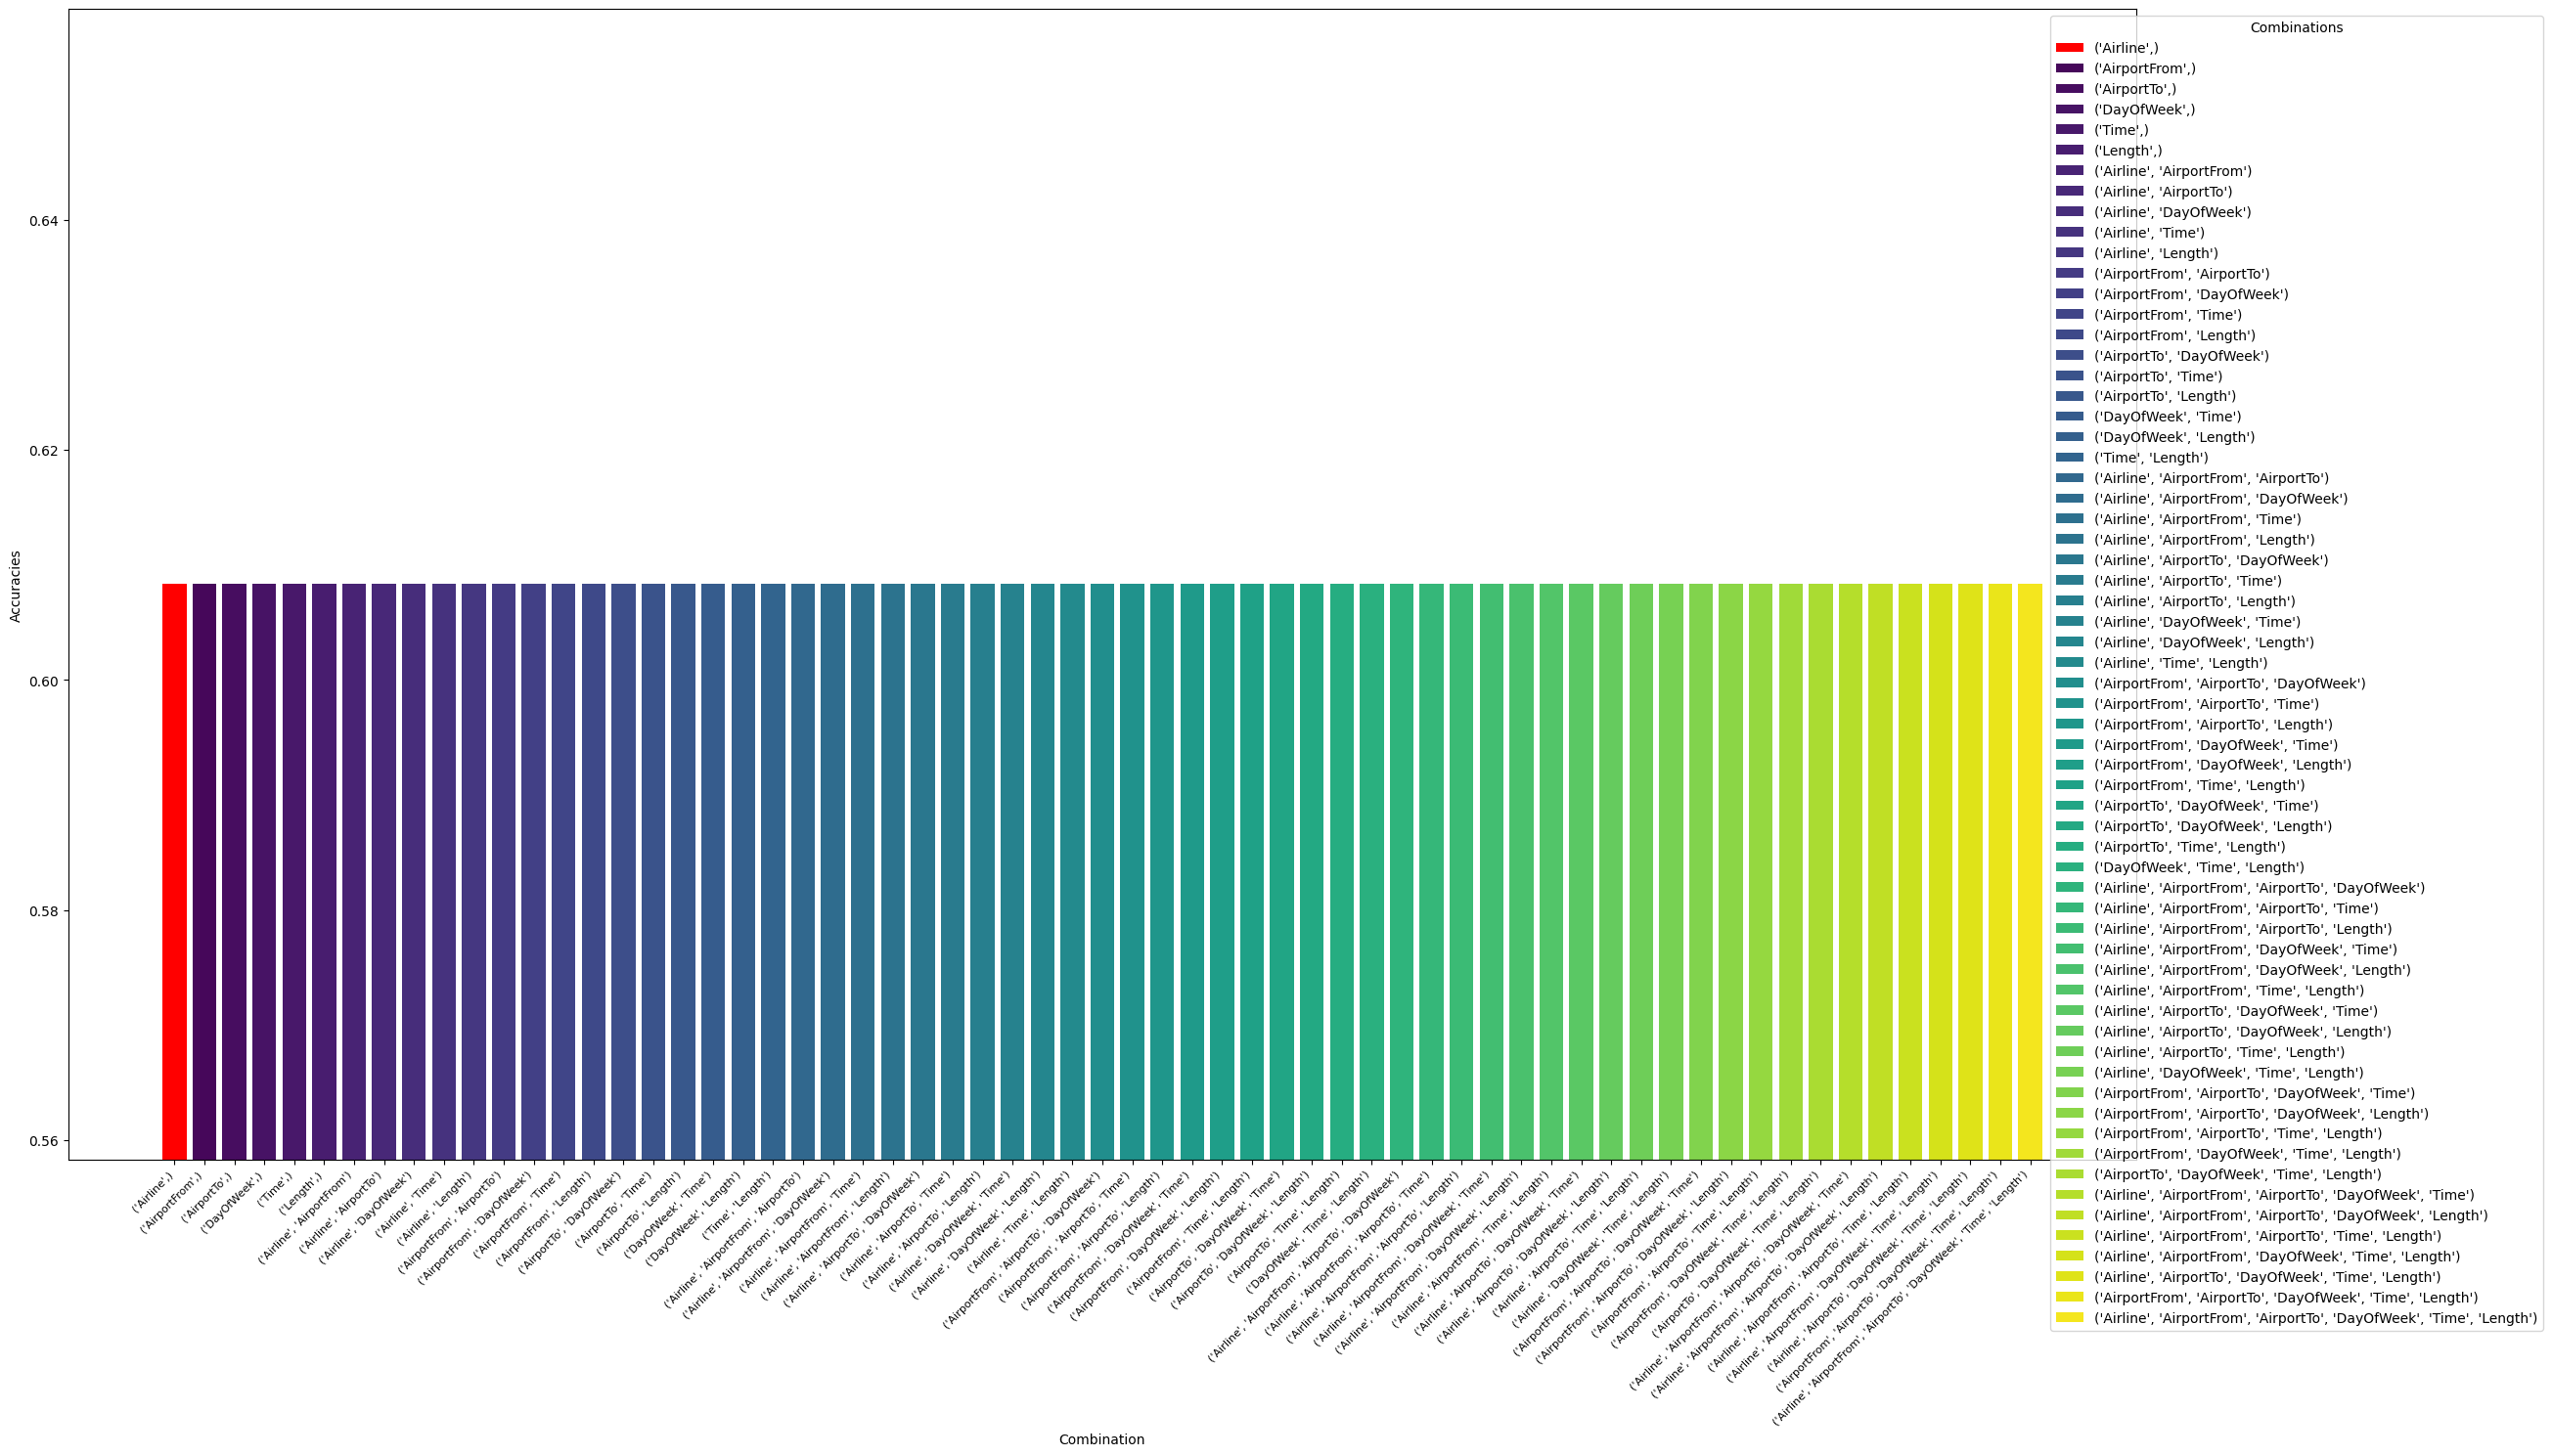

In [21]:
# Extrahiere die benötigten Daten
combinations = [str(entry[1]) for entry in big_data]
accuracies = [entry[2] for entry in big_data]

# Festlegen von verschiedenen Farben für jeden Balken
colors = plt.cm.viridis(np.linspace(0, 1, len(combinations)))

# Find the index of the maximum accuracy value
max_acc_index = np.argmax(accuracies)

# Create a list of colors, setting 'red' for the maximum average value and 'viridis' for others
highlighted_colors = ['red' if i == max_acc_index else plt.cm.viridis(i / len(combinations)) for i in range(len(combinations))]

# Plot
fig, ax = plt.subplots(figsize=(26, 15))
bars = ax.bar(combinations, accuracies, color=highlighted_colors)

# Reduziere die Anzahl der x-Achsenbeschriftungen
x_ticks = range(0, len(combinations), 1)  # Adjust the step size according to your preference
plt.xticks(x_ticks, [combinations[i] for i in x_ticks], rotation=45, ha='right', fontsize=8)  # Rotate labels by 45 degrees

# Set y-axis limits for better visibility
plt.ylim(min(accuracies) - 0.05, max(accuracies) + 0.05)

# Achsentitel hinzufügen
plt.xlabel('Combination')
plt.ylabel('Accuracies')

# Farblegende hinzufügen
plt.legend(bars, combinations, title='Combinations', loc='upper right', bbox_to_anchor=(1.2, 1))

# Vergrößere den Abstand zwischen den Balken
plt.tight_layout()

# Diagramm anzeigen
plt.savefig("graphs/dtCombinations7.pdf")
plt.show()

As you can see, the best accuracy with the fewest columns is actually only Airline.